# Sentiment analysis of drug reviews
- In this project, we will first develop a model to predict the sentiment of a review based solely on the contents of the review. This information will later be used along with other available data to create a final prediction.
- The dataset we will use is available from [Kaggle](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018).
## Data exploration
- We will start off with a brief introduction to the data we will be working with.

In [1]:
# suppress unecessary tf info 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from prep_data import * 
from models import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("drugsComTest_raw.csv")
df.drop(columns="uniqueID", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   drugName     53766 non-null  object
 1   condition    53471 non-null  object
 2   review       53766 non-null  object
 3   rating       53766 non-null  int64 
 4   date         53766 non-null  object
 5   usefulCount  53766 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


- This dataset does contain some missing values in the `condition` column, which we will replace with a representation that the model we will use later can handle easier.

In [3]:
df.fillna({"condition": "missing"}, inplace=True)

- Let's look at some examples of the entries we have in this dataset. 

In [4]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


- We can see that in some of the reviews there is a sequence of symbols, that feels out of place, it was probably supposed to be an apostrophe. We will modify the reviews to fix this problem as well as other small modifications that will help our models use these reviews.

In [5]:
df['review'] = df['review'].str.lower().str.replace(r"[^\w\s]+|\d+|\s+", " ", regex=True)

- Next we will use descriptive statistics to get a better understanding of the numerical features.

In [6]:
df.describe()

,rating,usefulCount
count,53766.000000,53766.000000
mean,6.976900,27.989752
std,3.285207,36.172833
min,1.000000,0.000000
25%,4.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,949.000000


- The average `rating` in our dataset is almost 7, which is surprisingly high. This will mean that our dataset is imbalanced in favour of positive reviews, since we will regard any rating with 6 or higher a positive review.
- `usefulCount` has a really large range of values, which could be problematic. This feature itself might not be very useful for our problem, but we will let our models decide its importance.
- We will modify the rating column to suit our needs and then move on to the other features.

In [7]:
# convert ratings to positive/negative
df["rating"] = df["rating"].apply(lambda x: 1 if x > 5 else 0)

In [8]:
df.describe(include="object")

,drugName,condition,review,date
count,53766,53766,53766,53766
unique,2637,709,48229,3566
top,Levonorgestrel,Birth Control,good,11-Apr-17
freq,1273,9648,16,56


- There are a a lot of different values in the `drugName` column, as well as the `condition` column.
- It is interesting that there are 5000 reviews, which contain the same words as another review. When looking at the most frequent review it becomes apparent how easily this can happen.
- The `date` feature will have to be modified in a way that could provide some insight, perhaps a review is more likely to be positive in a specific month. We explore some options later in this project.
- Now we will focus on the feature `condition`, starting with a visualisation regarding the most frequent conditions as well as visualisations comparing the sentiments of ratings behave for these conditions.

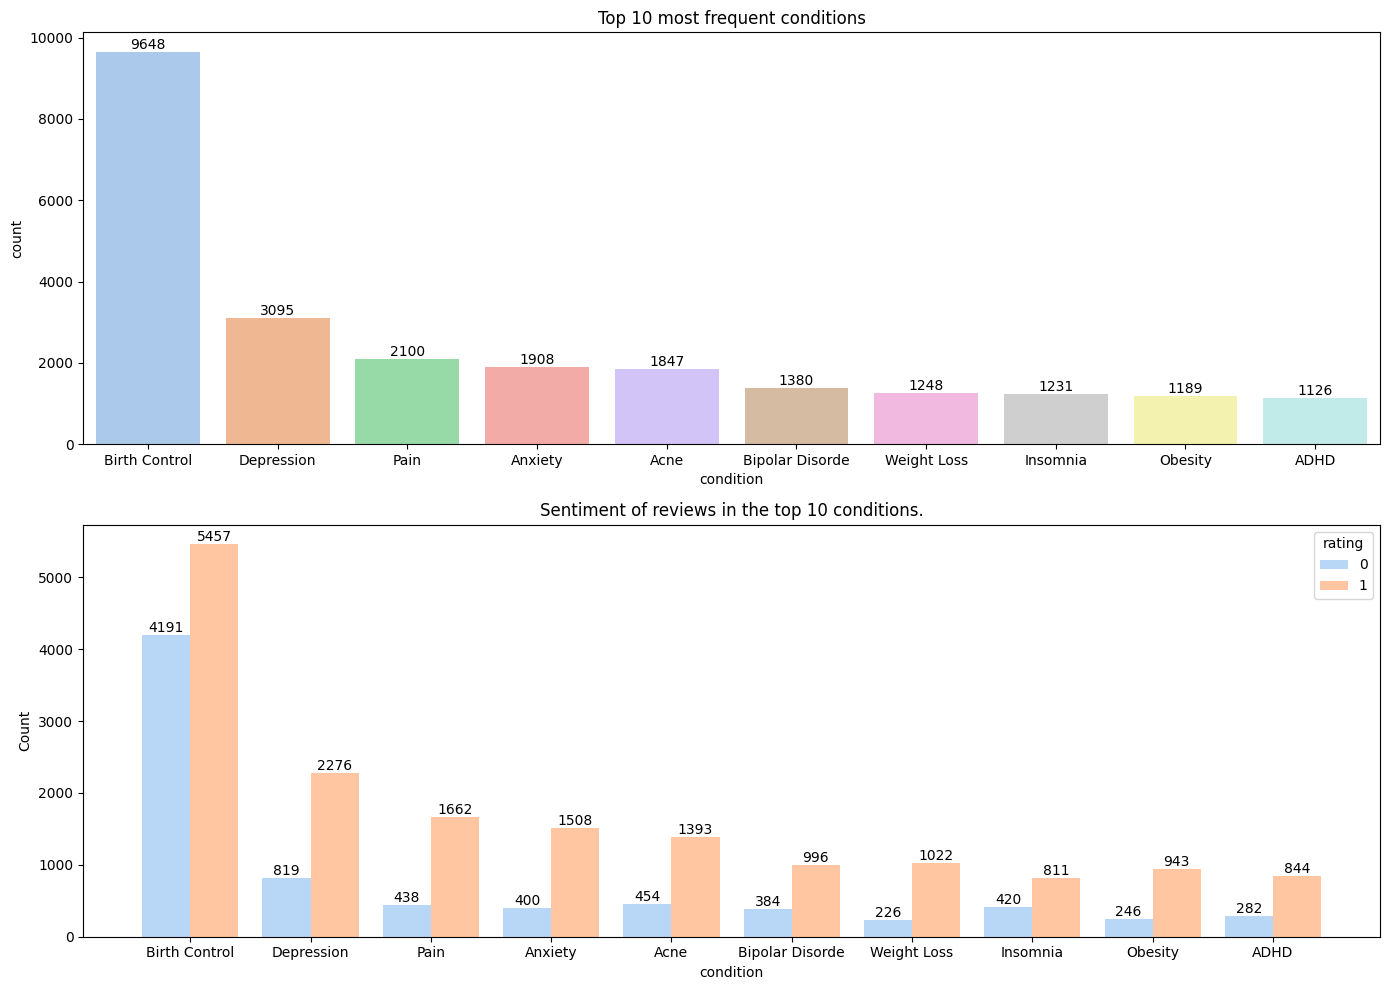

In [9]:
top_conditions = df["condition"].value_counts().head(10).index.tolist()
top_df = df[df["condition"].isin(top_conditions)].copy()
top_df["condition"] = pd.Categorical(top_df["condition"], categories=top_conditions, ordered=True)
top_df.sort_values(by="condition", inplace=True)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
# regular sns countplot 
sns.countplot(data=top_df, x="condition", ax=ax1, hue="condition", palette="pastel").set(title="Top 10 most frequent conditions")
for container in ax1.containers:
    ax1.bar_label(container)
# split of positive to negative reviews    
sns.histplot(data=top_df, x="condition", hue="rating", multiple="dodge", ax=ax2, palette="pastel", shrink=.8, edgecolor=None).set(title="Sentiment of reviews in the top 10 conditions.")
for container in ax2.containers:
    ax2.bar_label(container)
plt.tight_layout()
plt.show()

- We can see that there more than three times as many reviews for birth control than depression and after that the drop off is not so sharp. 
- The second graph shows us that for each condition the likelihood of the review being positive varies quite a bit, indicating that this feature could be useful for our models.
- Next we will create a similar graphs, which will show us if perhaps the month or year when the review was published affects the likelihood of the review being positive.

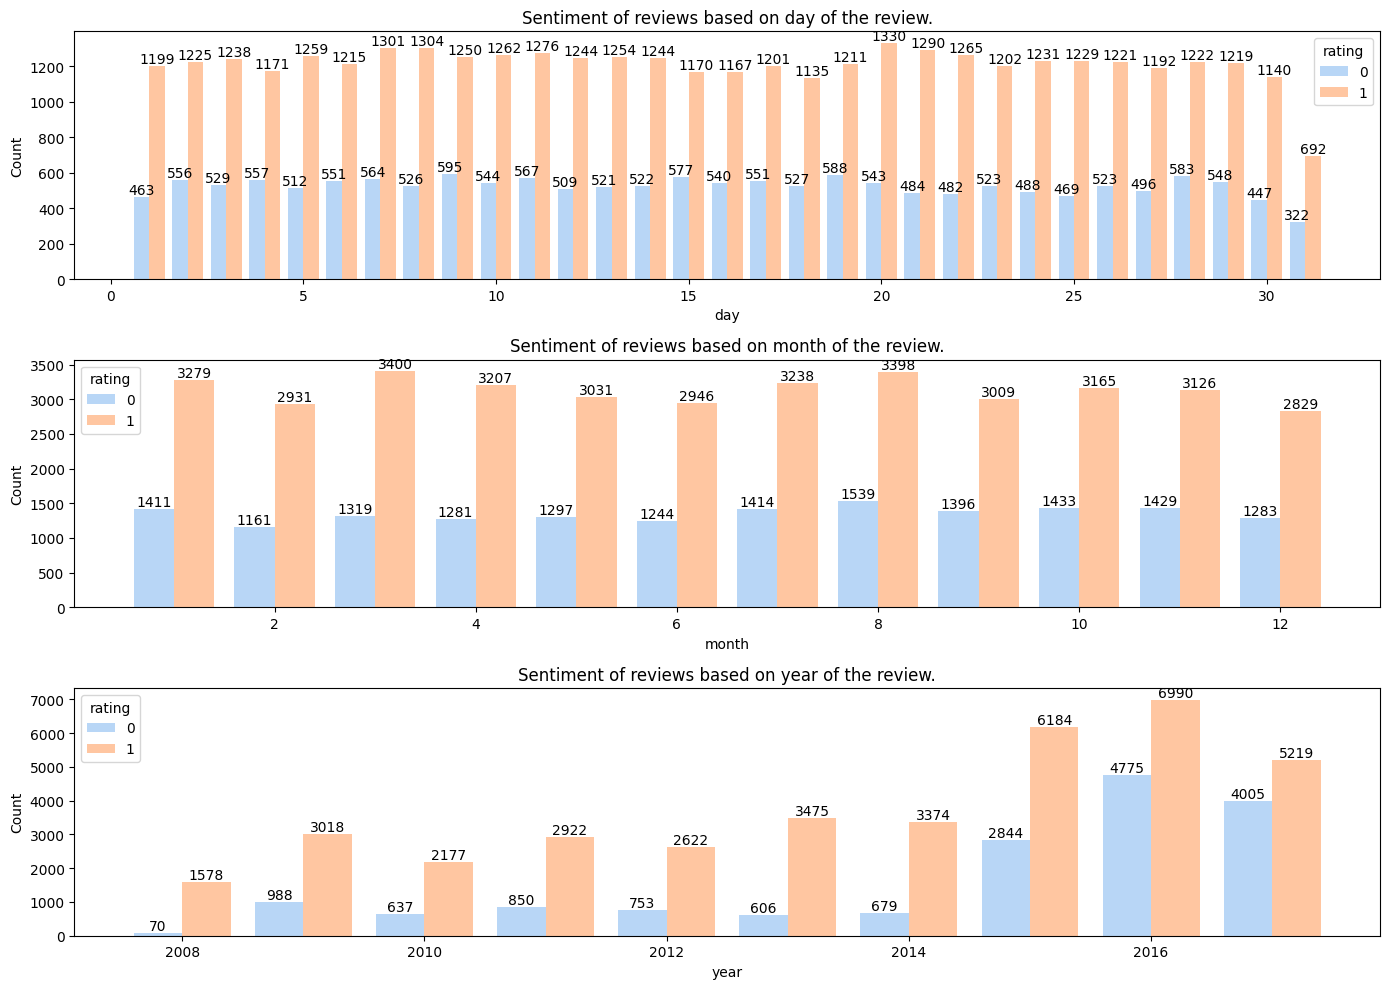

In [10]:
# prepare data for visualising
df["date"] = pd.to_datetime(df["date"], format='%d-%b-%y')
# extract new features
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10))
# by day
sns.histplot(data=df, x="day", hue="rating", multiple="dodge", ax=ax1, palette="pastel", shrink=.8, edgecolor=None, discrete=True).set(title="Sentiment of reviews based on day of the review.")
for container in ax1.containers:
    ax1.bar_label(container)
# by month
sns.histplot(data=df, x="month", hue="rating", multiple="dodge", ax=ax2, palette="pastel", shrink=.8, edgecolor=None, discrete=True).set(title="Sentiment of reviews based on month of the review.")
for container in ax2.containers:
    ax2.bar_label(container)

# by year
sns.histplot(data=df, x="year", hue="rating", multiple="dodge", ax=ax3, palette="pastel", shrink=.8, edgecolor=None, discrete=True).set(title="Sentiment of reviews based on year of the review.")
for container in ax3.containers:
    ax3.bar_label(container)
plt.tight_layout()
plt.show()

- As we can see from these graphs, the month of the review does not change the probability of the review being positive very much, whereas the year of the review has a large impact. We will replace the original feature with these newly created features. 
- Before we start creating ML models, we will prepare our textual data to suit the needs of these models and split our data into train, validation and test sets. To improve readability of this notebook, most of the necessary code will be imported from a separate python file.

In [11]:
df.drop(columns="date", inplace=True)
# train test split
random_seed = 281        
Xtrain, Xrest, ytrain, yrest = train_test_split(df.drop(columns=["rating"]), df["rating"], test_size=0.4, random_state=random_seed)
Xval, Xtest, yval, ytest = train_test_split(Xrest, yrest, test_size=0.5, random_state=random_seed)
# preprocess data
vocab, vocab_len = create_vocab(Xtrain)
X_train, idx_train = prep_review(Xtrain, vocab)
X_val, idx_val = prep_review(Xval, vocab)
X_test, idx_test  = prep_review(Xtest, vocab)

## Sentiment analysis
- Now we can finally start creating some models. This sections focuses on predicting the sentiment of the review only based on the content of the review. We will try some of the most commonly used types of neural networks for sentiment analysis.
- The computation time needed to train these models on this dataset is quite high, which is why we will only try a few variants of each model.
### Simple recurrent neural networks
- The first model we will be using for this task is a simple recurrent neural network (RNN). This model has a way to retain information from previous inputs allowing the RNN to use previous context to influence the final prediction, which makes it suitable for this task.

In [12]:
tuner = RandomSearch(
    hypermodel=lambda hp: build_rnn(hp, vocab_len),
    max_trials=3,
    objective='val_accuracy',
    directory='tuner',
    project_name='rnn'
)
best_rnn = tf.keras.callbacks.ModelCheckpoint(
    "models/rnn.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
tuner.search(X_train, ytrain, epochs=5, validation_data=(X_val, yval), callbacks=[best_rnn])
print(tuner.get_best_hyperparameters(1)[0].values)
rnn = tf.keras.models.load_model("models/rnn.keras")
print(f"Validation accuracy: {rnn.evaluate(X_val, yval)[1]:.4f}")

Reloading Tuner from tuner/rnn/tuner0.json
{'num_units': 128}
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6994 - loss: 0.6146
Validation accuracy: 0.6935


- With this type of model, we were unable to to achieve an accuracy of more than 0.7 on the validation dataset, which is not very promising. This was achieved by the model with the highest number of units. Although it might be wortwhile to try a network with more RNN layers, we will now focus on different types of models and perhaps explore this option if we are unable to improve performance using the other types of models.
### Gated reccurent unit
- The Gated reccurent unit (GRU) addresses the vanishing gradient problem of the previous model, which can cause its inability to capture long-term dependencies. This is done using two gates, which control the flow of information.

In [13]:
tuner = RandomSearch(
    hypermodel=lambda hp: build_gru(hp, vocab_len),
    max_trials=4,
    objective='val_accuracy',
    directory='tuner',
    project_name='gru'
)
best_gru = tf.keras.callbacks.ModelCheckpoint(
    "models/gru.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
tuner.search(X_train, ytrain, epochs=5, validation_data=(X_val, yval), callbacks=[best_gru])
print(tuner.get_best_hyperparameters(1)[0].values)
gru = tf.keras.models.load_model("models/gru.keras")
print(f"Validation accuracy: {gru.evaluate(X_val, yval)[1]:.4f}")

Reloading Tuner from tuner/gru/tuner0.json
{'num_units': 32}
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6994 - loss: 0.6115
Validation accuracy: 0.6935


- We expected this model to outperform the previous model, but it performed indentically (when the validation accuracy was rounded to four decimal places) compared to the RNN. Unlike with the RNN we have one other version of this type of model we will try.
- The next model we will focus on is a slight modification of the GRU, called a Bidirectional GRU, which consist of two GRU layers: Forward GRU and Backward GRU, they enable it to capture context from both directions. This extra information should allow for improved performance. 

In [14]:
tuner = RandomSearch(
    hypermodel=lambda hp: build_bigru(hp, vocab_len),
    max_trials=4,
    objective='val_accuracy',
    directory='tuner',
    project_name='bigru'
)
best_bigru = tf.keras.callbacks.ModelCheckpoint(
    "models/bigru.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
tuner.search(X_train, ytrain, epochs=5, validation_data=(X_val, yval), callbacks=[best_bigru])
print(tuner.get_best_hyperparameters(1)[0].values)
bigru = tf.keras.models.load_model("models/bigru.keras")
print(f"Validation accuracy: {bigru.evaluate(X_val, yval)[1]:.4f}")

Reloading Tuner from tuner/bigru/tuner0.json
{'num_units': 256}
337/337 ━━━━━━━━━━━━━━━━━━━━ 84s 246ms/step - accuracy: 0.8457 - loss: 0.3619
Validation accuracy: 0.8431


- We saw a significant improvement compared to the previous two models. This might be a candidate for the best model overall.
### Long short-term memory
- The Long short-term memory (LSTM) is more complex than the GRU, along with a more intricate gate mechanism, this model uses a cell state, which allows the model to remember information over long periods. The added complexity leads to longer training time.

In [15]:
tuner = RandomSearch(
    hypermodel=lambda hp: build_lstm(hp, vocab_len),
    max_trials=4,
    objective='val_accuracy',
    directory='tuner',
    project_name='lstm'
)
best_lstm = tf.keras.callbacks.ModelCheckpoint(
    "models/lstm.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
tuner.search(X_train, ytrain, epochs=5, validation_data=(X_val, yval), callbacks=[best_lstm])
print(tuner.get_best_hyperparameters(1)[0].values)
lstm = tf.keras.models.load_model("models/lstm.keras")
print(f"Validation accuracy: {lstm.evaluate(X_val, yval)[1]:.4f}")

Reloading Tuner from tuner/lstm/tuner0.json
{'num_units': 256}
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.6994 - loss: 0.6116
Validation accuracy: 0.6935


- Even though this is an even more complex network, it has achieved the nearly identical accuracy as the models with only one layer, showing that just this one layer is simply not enough to capture information necessary to achieve a higher level of performance.
- Similarly to the last model, there is also a Bidirectional version of the LSTM, which we will try out now and hopefully see a similar boost in performance when compared to the regular LSTM.

In [16]:
tuner = RandomSearch(
    hypermodel=lambda hp: build_bilstm(hp, vocab_len),
    max_trials=4,
    objective='val_accuracy',
    directory='tuner',
    project_name='bilstm'
)
best_bilstm = tf.keras.callbacks.ModelCheckpoint(
    "models/bilstm.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
tuner.search(X_train, ytrain, epochs=5, validation_data=(X_val, yval), callbacks=[best_bilstm])
print(tuner.get_best_hyperparameters(1)[0].values)
bilstm = tf.keras.models.load_model("models/bilstm.keras")
print(f"Validation accuracy: {bilstm.evaluate(X_val, yval)[1]:.4f}")

Reloading Tuner from tuner/bilstm/tuner0.json
{'num_units': 32}
337/337 ━━━━━━━━━━━━━━━━━━━━ 124s 367ms/step - accuracy: 0.8305 - loss: 0.4054
Validation accuracy: 0.8289


- This model achieved very similar performance compared to the Bidirectional GRU, but ultimately had worse performance. We could see some overfitting with these models, which we would prevent with some form of regularization, such as dropout.
- The best performing model overall was the Bidirectional GRU with 256 units, which is the model we will now use to predict sentiment of the review.
- The model returns values in the range [0,1], which conveys more information regarding the sentiment, than if we only had binary predictions, so we will not be converting the output to binary values.

In [17]:
best_model = tf.keras.models.load_model("models/bigru.keras")
Xtrain["sentiment"] = best_model.predict(X_train)
Xval["sentiment"] = best_model.predict(X_val)
Xtest["sentiment"] = best_model.predict(X_test)

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 736s 729ms/step
337/337 ━━━━━━━━━━━━━━━━━━━━ 111s 326ms/step
337/337 ━━━━━━━━━━━━━━━━━━━━ 115s 342ms/step


In [18]:
# getting rid of the reviews, since we already used a special model to handle them
Xtrain.drop("review", axis=1, inplace=True)
Xval.drop("review", axis=1, inplace=True)
Xtest.drop("review", axis=1, inplace=True)

## Final model
- Now that we have created a new feature, we will use it in a final model that will take into account the other available features as well. Even though the newly created feature should be the most important in the prediction, we still might find an improvement in performance.
- We will be testing out a two models for this task, starting off with the CatBoost model, which is based on gradient boosting on decision trees.
- This particular model handles categorical features exceptionally well. All features in this modified dataset are categorical, expect for `usefulCount` and `sentiment`, meaning this model should be a good fit for the task at hand. 

In [19]:
# select all columns except sentiment and usefulCout
cols = Xtrain.select_dtypes(exclude=["int64", "float32"]).columns
cat_idx = np.where(Xtrain.columns.isin(cols))[0]

cat_clf = CatBoostClassifier(cat_features=cat_idx, verbose=0)
cat_clf.fit(Xtrain, ytrain)
print(f"Validation accuracy: {cat_clf.score(Xval, yval):.4f}")

Validation accuracy: 0.8506


- There was a slight improvement in accuracy, but as we might have expected, since there is not a lot of insight on the sentiment of the review in the other features. 
- The next model we will try is a generalized additive model with interactions. We have chosen this model in particular, because of its interpretability, which allows us to examine to e features it perceives as important.

In [20]:
ebm = ExplainableBoostingClassifier().fit(Xtrain, ytrain)
print(f"Validation accuracy: {accuracy_score(yval, ebm.predict(Xval)):.4f}")

Validation accuracy: 0.8453


- This model used the other other features slightly worse than the previous model, but still provided a small improvement on the neural network used to create the `sentiment` feature.

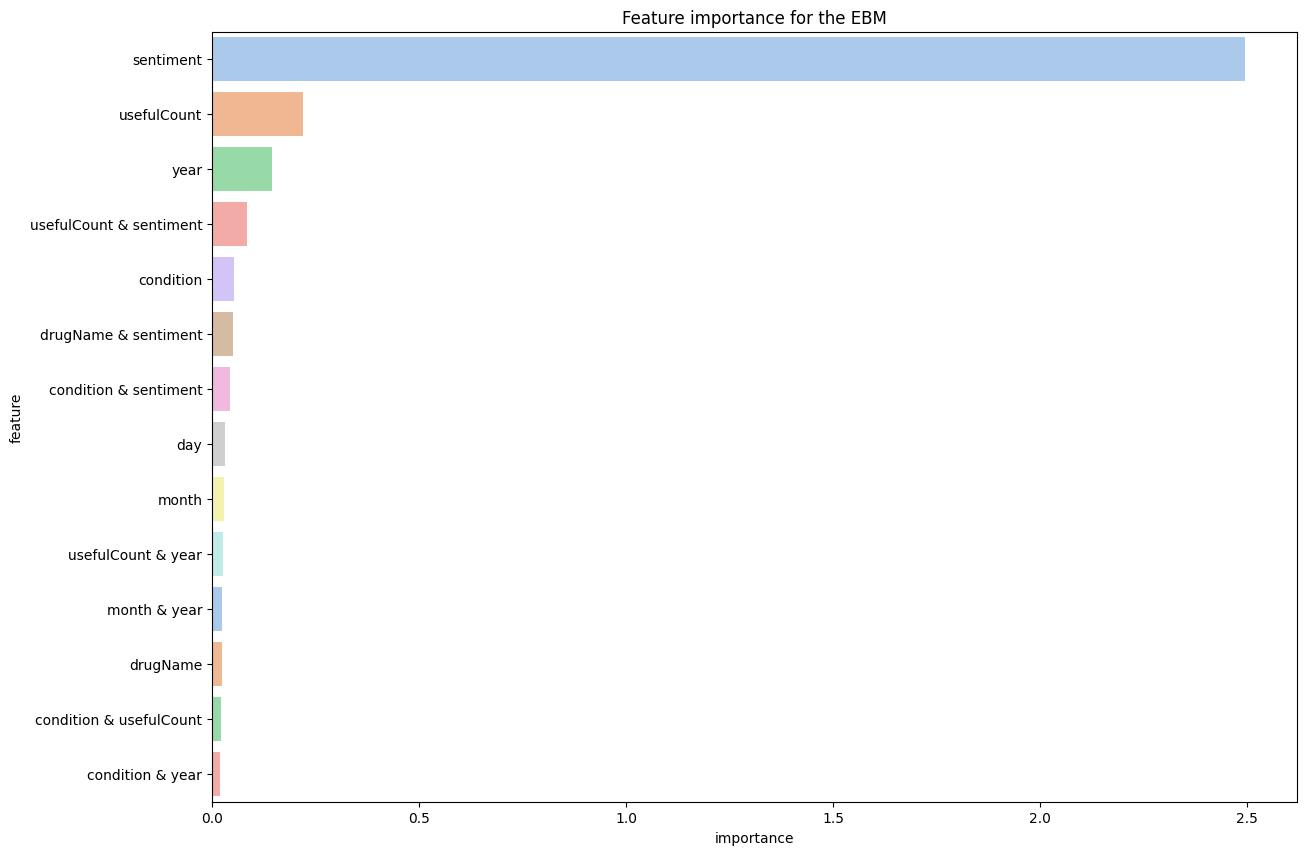

In [21]:
ebm_global = ebm.explain_global()
temp = pd.DataFrame({"feature": ebm_global.data()["names"], "importance": ebm_global.data()["scores"]})
temp.sort_values(by="importance", ascending=False, inplace=True)

plt.figure(figsize=(14, 10))
sns.barplot(x="importance", y="feature", data=temp, palette="pastel", hue="feature").set(title="Feature importance for the EBM")
plt.show()

In [22]:
# nicer alternative with the same but interactive plot along with other plots, but needs to rerun the whole notebook to work, which takes a few minutes.
# show(ebm_global)

- As we can see from the graph above, the model barely used any features other than the `sentiment`, explaining why the performance was almost identical to the neural network used to create this feature.
- Now we will use the CatBoost model to estimate the performance of the model on unseen data. 

In [23]:
print(f"Test accuracy: {accuracy_score(ytest, cat_clf.predict(Xtest)):.4f}")

Test accuracy: 0.8484


- With the CatBoost model, used on top of sentiment predictions generated by a Bidirectional GRU neural network, we could expect an accuracy of around 0.85 on real-world data.